Output()

train_loss    0.172275
valid_loss    0.424808
grad_norm     0.146363
train_acc     0.972976
valid_acc     0.886719
train_rmse    0.977523
valid_rmse    0.614701
dtype: float64

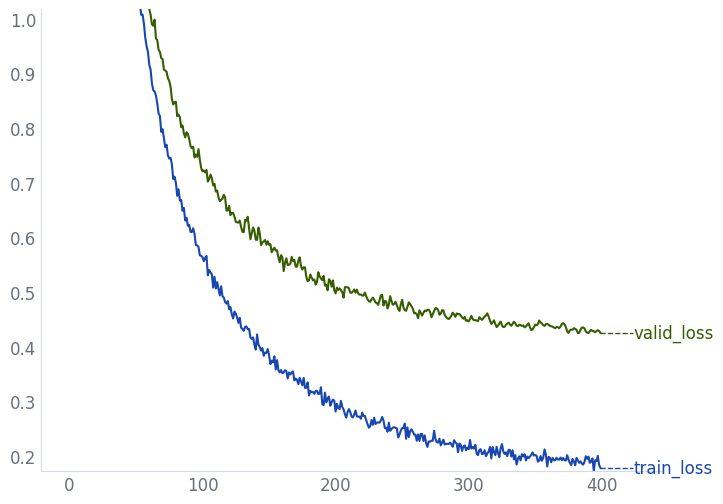

In [107]:
# jax.config.update('jax_debug_nans', True)
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rho_plus as rp
import seaborn as sns
from eins import ElementwiseOps as E
from flax import linen as nn

from jax_kan.trainer import Trainer

theme, cs = rp.mpl_setup(False)

import optax
import rich

from jax_kan.data import DataFrameDataLoader
from jax_kan.function_basis import Chebyshev, Fourier, Gegenbauer, Hermite, InputMap, Jacobi
from jax_kan.kan import KAN, KANLayer
from jax_kan.utils import Identity

rich.console.Console()
rich.reconfigure(force_jupyter=True, width=250)


batch_size = 128
n_folds = 10
start_frac = 0.8
end_frac = 0.2
warmup = 10
n_epochs = 400
dtype = jnp.float32

n_coef = 5
node_dropout = 0.05
hidden_dim = None
inner_dims = [64]
out_hidden_dim = None
normalization = Identity
base_act = nn.tanh
weight_decay = 0.01
base_lr = 8e-3
input_map = InputMap(
    stretch_base=1,
    stretch_trainable=False,
    map_type='tanh',
)
spline_kind = Gegenbauer
spline_params_share = True

# -------------------------------

df = pd.read_csv('datasets/one-hundred-plants.csv', index_col='id')
df['Class'] = df['Class'].astype(int)
dl = DataFrameDataLoader(df, batch_size=batch_size, target_col='Class')

steps_in_epoch = dl.train_valid_split(k=n_folds)[0].num_batches

kwargs = {
    'in_dim': dl.sample_batch().in_dim,
    'out_dim': np.max(dl.dataset.y).item() + 1,
    'final_act': lambda x: x,
    'inner_dims': inner_dims,
    'normalization': normalization,
    'hidden_dim': hidden_dim,
    'out_hidden_dim': out_hidden_dim,
    'layer_templ': KANLayer(
        1,
        1,
        n_coef=n_coef,
        dropout_rate=node_dropout,
        base_act=base_act,
        input_map=input_map,
        spline_kind=spline_kind,
        spline_params_share=spline_params_share,
    ),
}

sched = optax.cosine_onecycle_schedule(
    transition_steps=steps_in_epoch * n_epochs,
    peak_value=base_lr,
    pct_start=0.1,
    div_factor=1 / start_frac,
    final_div_factor=1 / end_frac,
)
opt = optax.nadamw(sched, weight_decay=weight_decay)
tx = optax.chain(opt)

kan = KAN(**kwargs)

trainer = Trainer(kan, dl, optimizer=tx)

for fold in range(1):
    trainer.use_fold(fold, k=n_folds)
    trainer.fit(n_epochs=n_epochs)

    display(
        trainer.epoch_df.agg(
            {
                'train_loss': 'min',
                'valid_loss': 'min',
                'grad_norm': 'max',
                'train_acc': 'max',
                'valid_acc': 'max',
                'train_rmse': 'min',
                'valid_rmse': 'min',
            }
        )
    )

    hist = trainer.epoch_df[['train_loss', 'valid_loss']]
    hist.plot()
    plt.ylim(hist.min().min(), hist.iloc[60:].max().max())
    rp.line_labels()
    plt.show()

In [95]:
from penzai import pz

pz.show(trainer.state.params)

TreescopeRenderingFigure(child=PreventWordWrap(child=Siblings(children=(WithDynamicSharedPip(child=FoldableTreeNodeImpl(contents=Siblings(children=(StringCopyButton(copy_string='(lambda root: root)', annotation='Copy path: '), IndentedChildren(children=[Siblings(children=(HyperlinkTarget(child=StringLiteralColor(child=Text(text="'layers_0'")), keypath=None), Text(text=': '), WithDynamicSharedPip(child=FoldableTreeNodeImpl(contents=Siblings(children=(StringCopyButton(copy_string="(lambda root: root['layers_0'])", annotation='Copy path: '), IndentedChildren(children=[Siblings(children=(HyperlinkTarget(child=StringLiteralColor(child=Text(text="'alpha'")), keypath=None), Text(text=': '), RoundtripCondition(roundtrip=WithBlockColor(child=FoldableTreeNodeImpl(contents=Siblings(children=(StringCopyButton(copy_string='(lambda root: root)', annotation='Copy path: '), ColoredBorderIndentedChildren(children=[Siblings(children=(Text(text='original_repr'), Text(text='='), HyperlinkTarget(child=StringLiteralColor(child=Text(text="'Array(-0.64323926, dtype=float32)'")), keypath=(GetAttrKey(name='original_repr'),)), Text(text=','), FoldCondition(collapsed=Text(text=' '), expanded=EmptyPart()), FoldCondition(collapsed=EmptyPart(), expanded=Siblings(children=(StringCopyButton(copy_string='(lambda root: root.original_repr)', annotation='Copy path: '),))))), Siblings(children=(Text(text='original_id'), Text(text='='), HyperlinkTarget(child=NumberColor(child=Text(text='900303312')), keypath=(GetAttrKey(name='original_id'),)), Text(text=','), FoldCondition(collapsed=Text(text=' '), expanded=EmptyPart()), FoldCondition(collapsed=EmptyPart(), expanded=Siblings(children=(StringCopyButton(copy_string='(lambda root: root.original_id)', annotation='Copy path: '),))))), Siblings(children=(Text(text='original_type'), Text(text='='), HyperlinkTarget(child=FoldableTreeNodeImpl(contents=FoldCondition(collapsed=EmptyPart(), expanded=IndentedChildren(children=[Siblings(children=(HyperlinkTarget(child=AbbreviationColor(child=Text(text="<class 'jax.Array'>")), keypath=(GetAttrKey(name='original_type'),)), FoldCondition(collapsed=EmptyPart(), expanded=Siblings(children=(StringCopyButton(copy_string='(lambda root: root.original_type)', annotation='Copy path: '),)))))])), label=CommentColorWhenExpanded(child=Siblings(children=(FoldCondition(collapsed=EmptyPart(), expanded=Text(text='# ')), QualifiedTypeNameSpanGroup(child=Text(text='jax.')), Text(text='Array')))), expand_state=<ExpandState.COLLAPSED: 'collapsed'>), keypath=(GetAttrKey(name='original_type'),)), FoldCondition(collapsed=EmptyPart(), expanded=Text(text=',')), FoldCondition(collapsed=EmptyPart(), expanded=Siblings(children=(StringCopyButton(copy_string='(lambda root: root.original_type)', annotation='Copy path: '),)))))]), ColoredBottomLineSpanGroup(child=Text(text=')')))), label=HyperlinkTarget(child=ColoredTopLineSpanGroup(child=Siblings(children=(RoundtripCondition(roundtrip=QualifiedTypeNameSpanGroup(child=Text(text='penzai.treescope.copypaste_fallback.')), not_roundtrip=EmptyPart()), Text(text='NotRoundtrippable'), Text(text='(')))), keypath=()), expand_state=<ExpandState.WEAKLY_COLLAPSED: 'weakly_collapsed'>), color='#db845a'), not_roundtrip=AbbreviationColor(child=Text(text='<jax.Array(-0.64323926, dtype=float32)>'))), Text(text=','), FoldCondition(collapsed=Text(text=' '), expanded=EmptyPart()), FoldCondition(collapsed=EmptyPart(), expanded=Siblings(children=(StringCopyButton(copy_string="(lambda root: root['layers_0']['alpha'])", annotation='Copy path: '),))))), Siblings(children=(HyperlinkTarget(child=StringLiteralColor(child=Text(text="'coefs'")), keypath=None), Text(text=': '), WithDynamicSharedPip(child=FoldableTreeNodeImpl(contents=Siblings(children=(StringCopyButton(copy_string="(lambda root: root['layers_0']['coefs'])", annotation='Copy path: '), IndentedChildren(children=[Siblings(children=(HyperlinkTarget(child=StringLiteralColor(child=Text(text="'bias'")), keypath=None), Text(text=': '

Text(0.5, 0.98, 'alpha = -0.643')

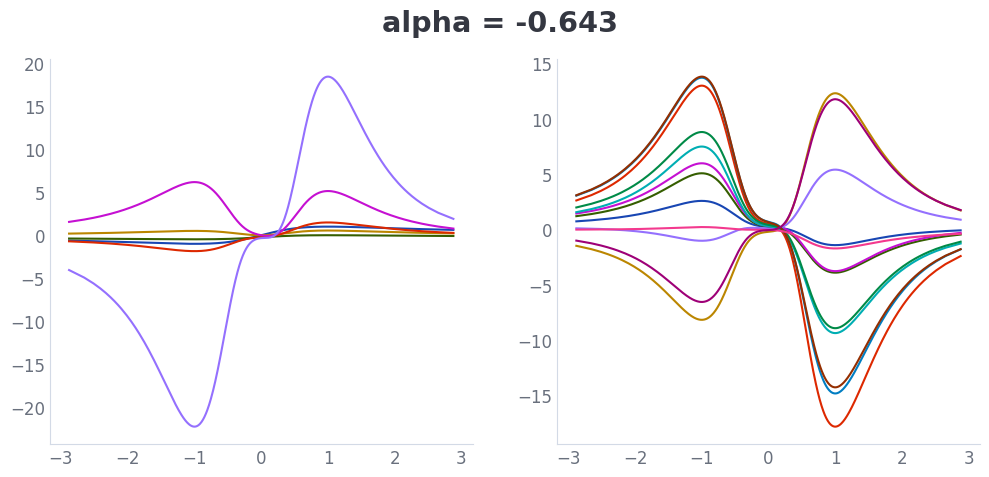

In [96]:
from scipy.stats import norm

Spline = trainer.model.layer_templ.spline_kind

layer: KANLayer = trainer.model.layer_templ
params = trainer.state.params

layer_i = 0
i = 15

layer_params = params[f'layers_{layer_i}']

base_xx = norm.ppf(jnp.linspace(0, 1, 502)[1:-1])

kernel = layer_params['coefs']['kernel']
in_dim, out_dim, n_coef = kernel.shape

xx = layer.input_map.apply({'params': layer_params.get('input_map', {})}, base_xx, layer.spline_kind)

if layer.spline_params_share:
    idx = lambda p: p
else:
    idx = lambda p: p[i]


spl_params = {param: idx(layer_params[param]) for param in layer.spline_kind.param_names()}

spl = Spline(kernel.shape[-1], **spl_params)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
dm = jax.vmap(spl.design_matrix)(xx)
ax1.plot(base_xx, dm)

outputs = jnp.einsum('oc,ic->io', kernel[i], dm) + layer_params['coefs']['bias'][i]
ax2.plot(base_xx, outputs[:, :12])


fig.suptitle(', '.join(f'{k} = {v:.03f}' for k, v in spl_params.items()))

In [9]:
jnp.array(0.3)[None]

Array([0.3], dtype=float32, weak_type=True)

In [ ]:
jnp.take(jnp.array([[1, 2, 3], [4, 5, 6]]), jnp.array([[1], [2]]))

In [ ]:
k = jnp.linspace(-1, 1, 8).reshape(2, 4)
print(k)
print(jax.nn.standardize(k, axis=0))

In [ ]:
trainer.epoch_df['grad_norm'].plot()

In [ ]:
eg = trainer.data.df['gap expt']
sns.kdeplot(eg[eg > 0], cut=0)

xx = np.random.randn(2000)
sns.kdeplot((xx + 2) ** 1.2, cut=0)

In [ ]:
nn.elu(-10) + 1

- better initialization: figure out mathematically how to make each layer roughly the identity
  without using residuals
- figure out why deep networks don't work well. Can we add skip connections, or residuals, or
  something?
- grid extension
- hermite polynomials?
- schedule API for general 0-1 functions, use for moving to L1 loss
- Gaussian dropout